# Predict the Credit_Mix category for a customer based on their financial data, and provide actionable insights to improve credit health.

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report,precision_score, recall_score, f1_score,  roc_auc_score


import warnings
warnings.filterwarnings('ignore')

In [50]:
# Read and preview data
url = 'https://raw.githubusercontent.com/rashakil-ds/Public-Datasets/refs/heads/main/Bank%20Data.csv'
df = pd.read_csv(url)
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,2022.0,Good,809.98,35.030402,22 Years and 9 Months,No,49.574949,236.64268203272135,Low_spent_Small_value_payments,186.26670208571772
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,Good,809.98,33.053114,22 Years and 10 Months,No,49.574949,21.465380264657146,High_spent_Medium_value_payments,361.44400385378196
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,Good,809.98,33.811894,NaN,No,49.574949,148.23393788500925,Low_spent_Medium_value_payments,264.67544623342997
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24_,821-00-0265,Scientist,19114.12,NaN,3,...,4.0,Good,809.98,32.430559,23 Years and 0 Months,No,49.574949,39.08251089460281,High_spent_Medium_value_payments,343.82687322383634
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,3037.986667,2,...,5.0,Good,605.03,25.926822,27 Years and 3 Months,No,18.816215,39.684018417945296,High_spent_Large_value_payments,485.2984336755923


In [51]:
df.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance'],
      dtype='object')

# Project Workflow

In order to do this project, must follow this structure....

## 1. Data Preprocessing
- Handle missing and invalid values in the dataset.
- Encode categorical variables appropriately.
- Scale and normalize numeric features for uniformity.
- Detect and address outliers to improve model stability.

In [52]:
# Check if any missing values
df.isnull().sum()

ID                             0
Customer_ID                    0
Month                          0
Name                        5015
Age                            0
SSN                            0
Occupation                     0
Annual_Income                  0
Monthly_Inhand_Salary       7498
Num_Bank_Accounts              0
Num_Credit_Card                0
Interest_Rate                  0
Num_of_Loan                    0
Type_of_Loan                5704
Delay_from_due_date            0
Num_of_Delayed_Payment      3498
Changed_Credit_Limit           0
Num_Credit_Inquiries        1035
Credit_Mix                     0
Outstanding_Debt               0
Credit_Utilization_Ratio       0
Credit_History_Age          4470
Payment_of_Min_Amount          0
Total_EMI_per_month            0
Amount_invested_monthly     2271
Payment_Behaviour              0
Monthly_Balance              562
dtype: int64

In [53]:
# Fill missing values 
for col in df.columns:
    if df[col].dtype == 'object':  # Non-numeric columns
        df[col] = df[col].fillna(df[col].mode()[0])
    else:  # Numeric columns
        df[col] = df[col].fillna(df[col].mean())

In [54]:
# Check if any missing values remain
print(df.isnull().sum())

ID                          0
Customer_ID                 0
Month                       0
Name                        0
Age                         0
SSN                         0
Occupation                  0
Annual_Income               0
Monthly_Inhand_Salary       0
Num_Bank_Accounts           0
Num_Credit_Card             0
Interest_Rate               0
Num_of_Loan                 0
Type_of_Loan                0
Delay_from_due_date         0
Num_of_Delayed_Payment      0
Changed_Credit_Limit        0
Num_Credit_Inquiries        0
Credit_Mix                  0
Outstanding_Debt            0
Credit_Utilization_Ratio    0
Credit_History_Age          0
Payment_of_Min_Amount       0
Total_EMI_per_month         0
Amount_invested_monthly     0
Payment_Behaviour           0
Monthly_Balance             0
dtype: int64


In [55]:
# Encode categorical variables
label_encoders = {}
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [56]:
# Scale numeric features
numeric_cols = df.select_dtypes(include=np.number).columns
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [57]:
# Detect and handle outliers using IQR
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

for col in numeric_cols:
    df = remove_outliers_iqr(df, col)

## 2. Exploratory Data Analysis (EDA)
- Perform descriptive statistics to understand the data distribution.
- Visualize relationships between features and the target variable.
- Analyze correlations and identify trends or anomalies in the data.

In [58]:
# Descriptive statistics
df.describe()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
count,25178.000000,25178.000000,25178.000000,25178.000000,25178.000000,25178.000000,25178.000000,25178.000000,25178.000000,25178.000000,...,25178.000000,25178.000000,25178.000000,25178.000000,25178.000000,25178.000000,25178.000000,25178.000000,25178.000000,25178.000000
mean,0.002855,-0.005947,0.006963,0.006065,-0.114106,0.000833,-0.002643,0.061259,-0.246903,-0.093135,...,-0.111564,-0.064925,-0.014077,-0.068496,-0.048999,0.175623,-0.160588,0.006848,0.065939,-0.182184
std,1.002826,0.999833,0.999837,1.003580,0.941259,0.996876,1.004720,0.968396,0.752541,0.021067,...,0.020398,1.084293,0.914748,0.981110,1.091754,1.013979,0.009903,1.005557,1.000782,0.928787
min,-1.732016,-1.731635,-1.341641,-1.833141,-1.997671,-1.556776,-1.619446,-1.738802,-1.325292,-0.153255,...,-0.154311,-1.553414,-1.727775,-2.305033,-1.654287,-2.024711,-0.173497,-1.748182,-1.701440,-1.732453
25%,-0.868312,-0.874686,-0.447214,-0.861554,-0.897783,-0.873239,-0.971441,-0.728970,-0.894743,-0.110298,...,-0.128661,-1.553414,-0.730170,-0.889497,-0.854561,-0.581890,-0.168240,-0.879771,-0.717937,-0.982102
50%,0.005335,-0.003603,0.447214,0.067279,-0.138796,0.000470,-0.107435,0.089947,-0.352982,-0.093116,...,-0.113271,0.427148,-0.040075,-0.069021,-0.440909,0.860931,-0.163978,0.047604,0.265565,-0.273996
75%,0.874911,0.855633,1.341641,1.029776,0.620191,0.857694,0.972573,0.878710,0.044504,-0.075933,...,-0.097881,0.427148,0.712502,0.754308,0.919544,0.860931,-0.154898,0.904388,1.249068,0.573057
max,1.732016,1.731912,1.341641,1.579871,2.942177,1.740238,1.620578,1.726275,2.209621,-0.050159,...,-0.067101,1.417428,1.724400,2.461971,2.004229,0.860931,-0.127980,1.468936,1.249068,1.693601


<Axes: >

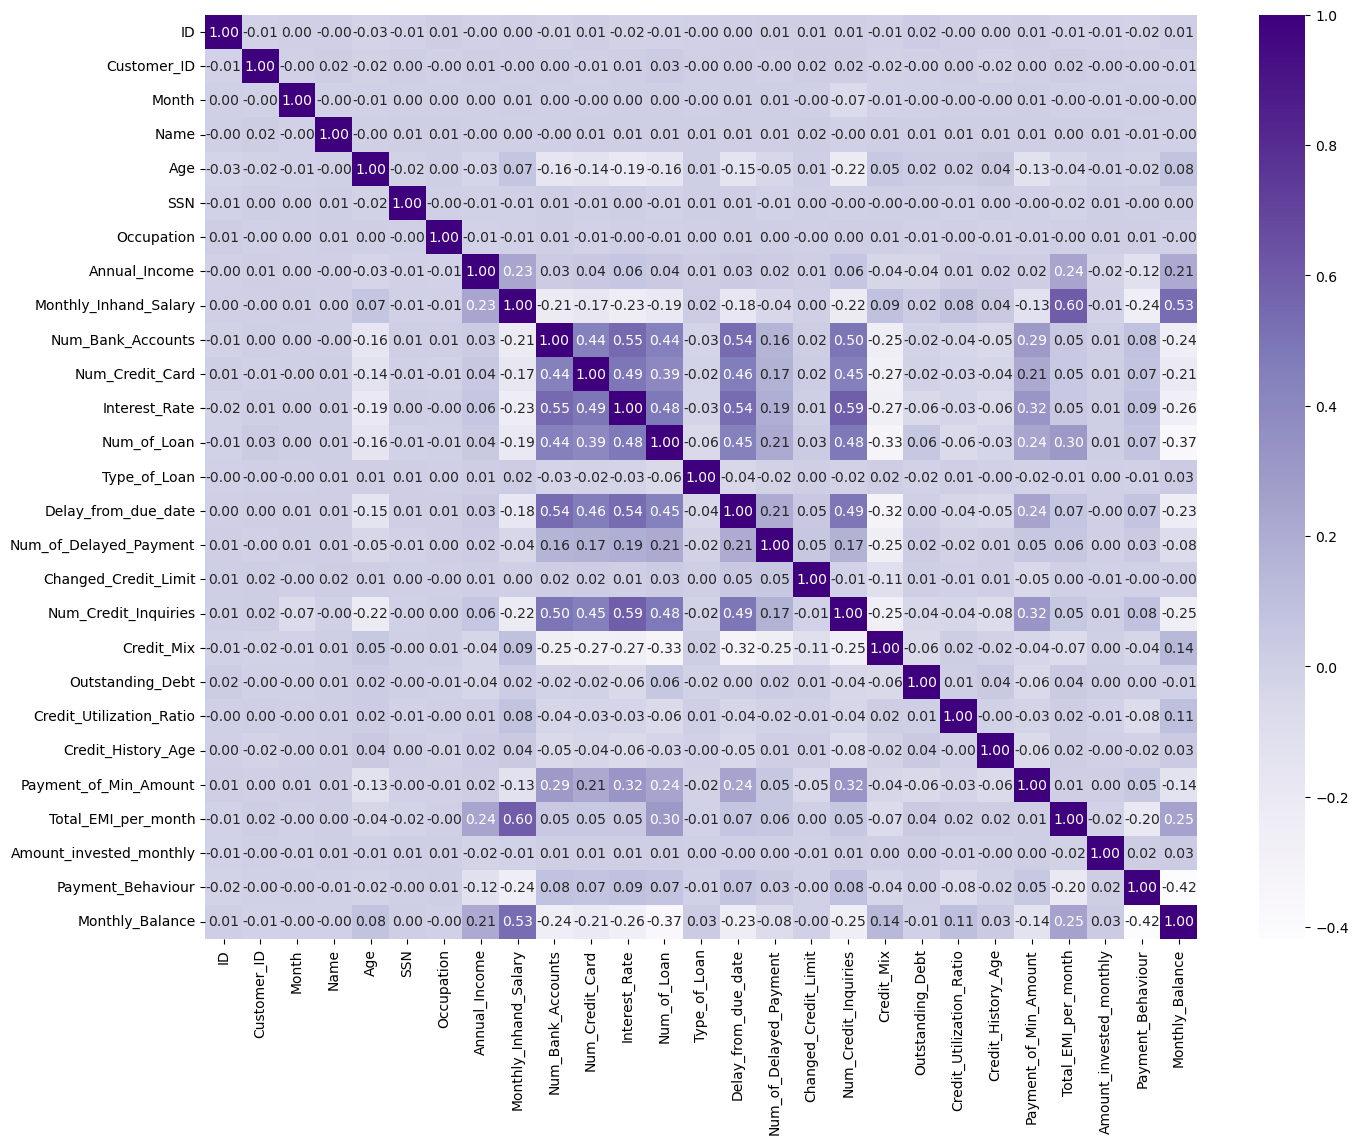

In [59]:
# Correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(), annot=True, cmap='Purples', fmt='.2f')

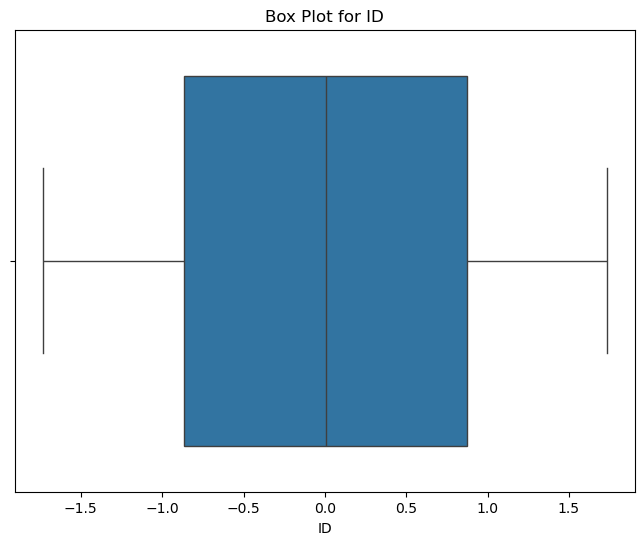

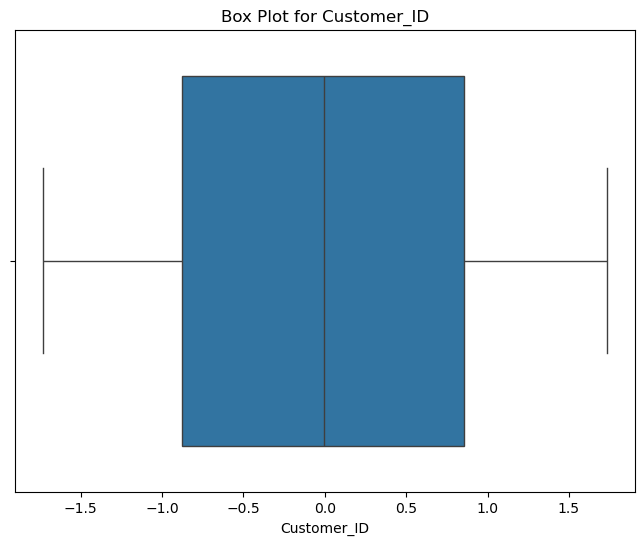

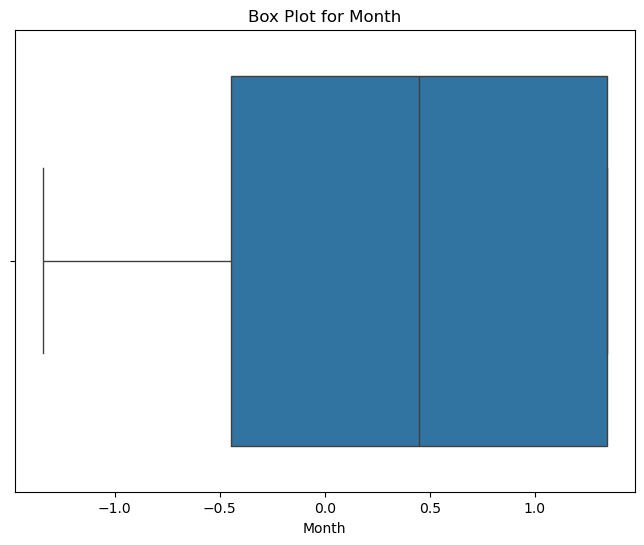

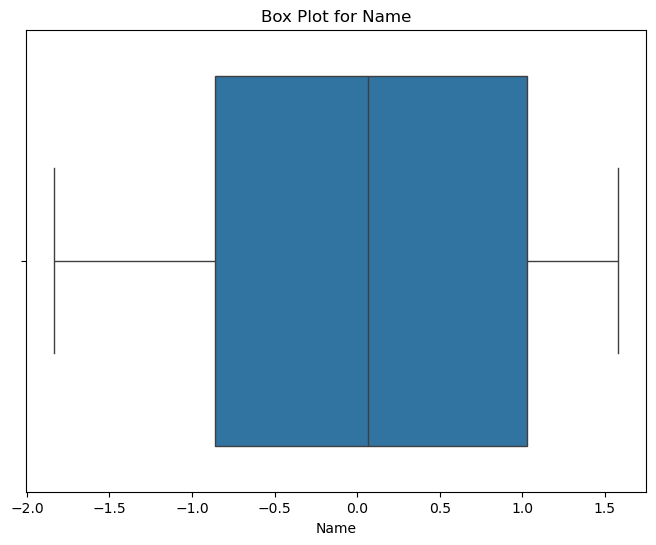

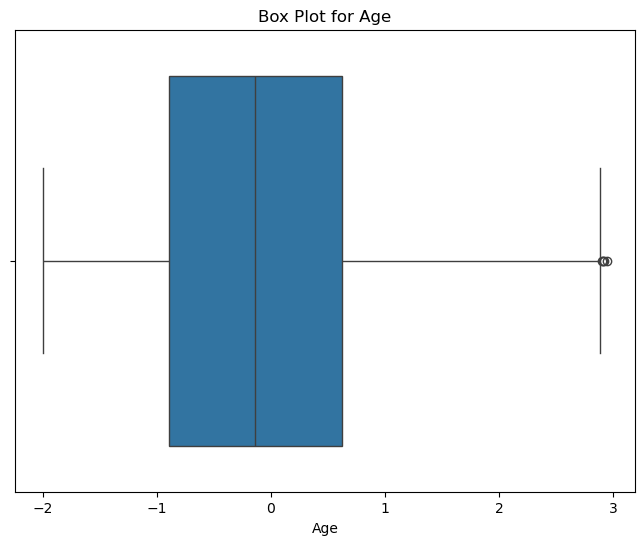

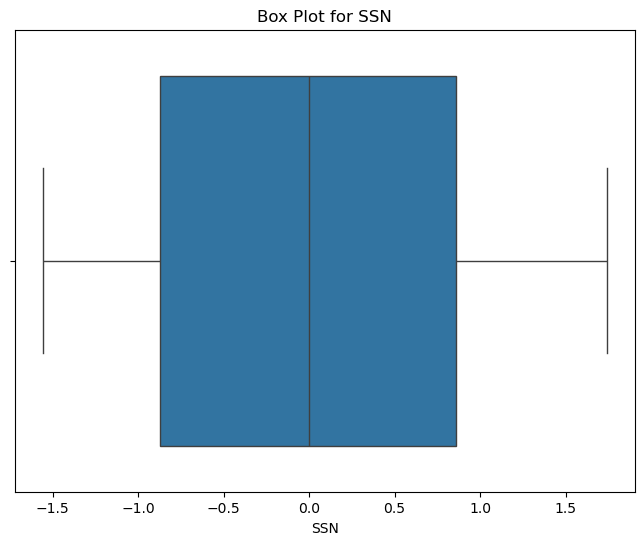

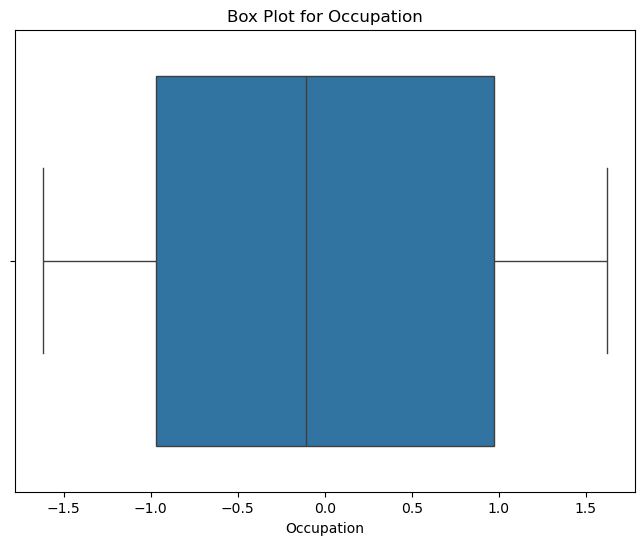

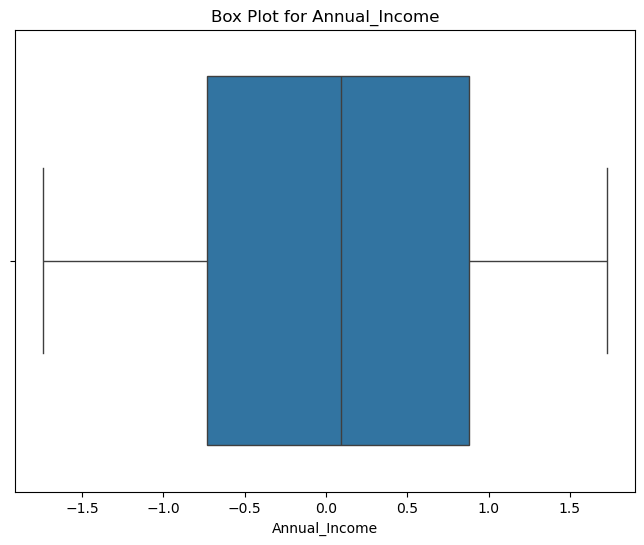

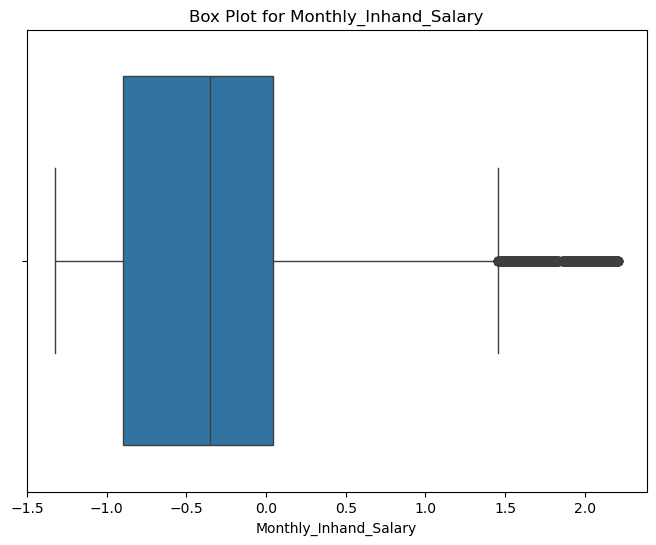

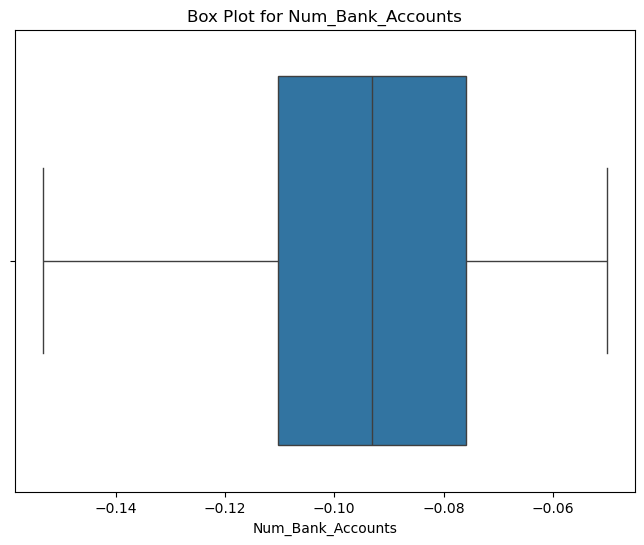

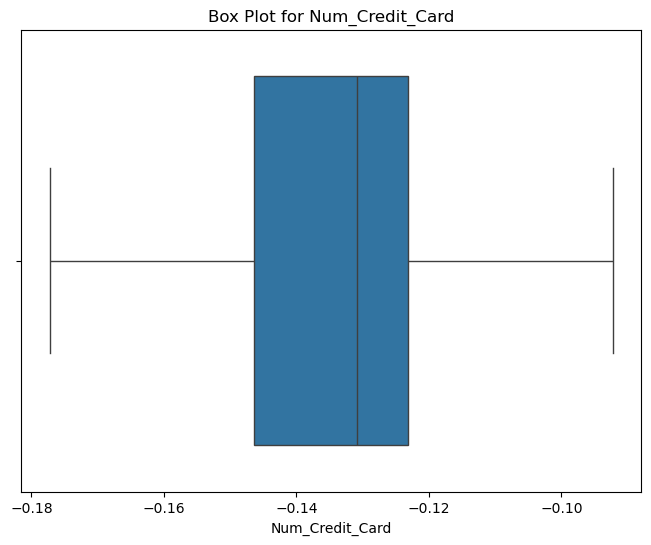

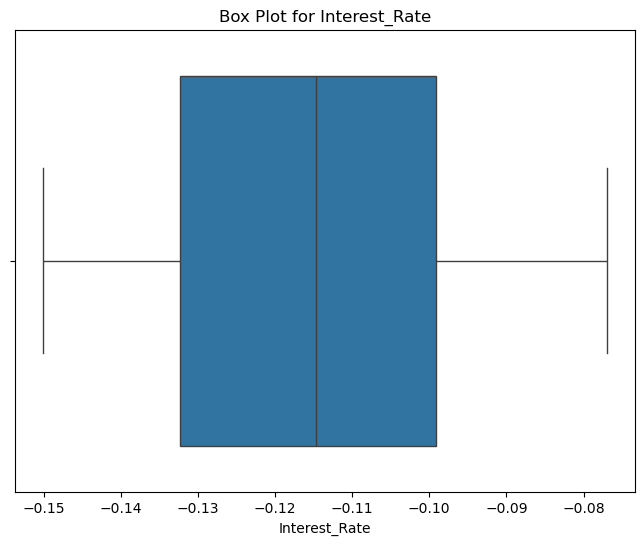

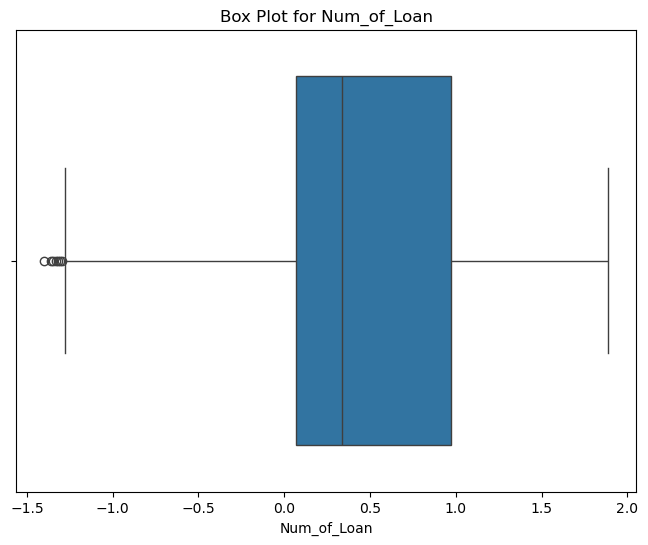

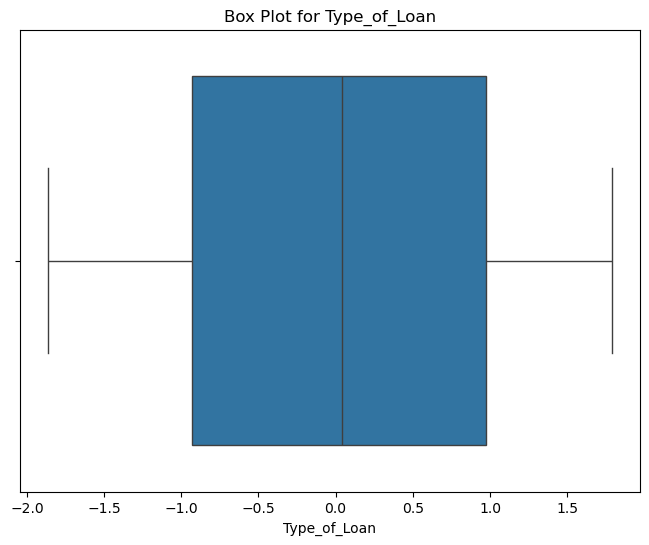

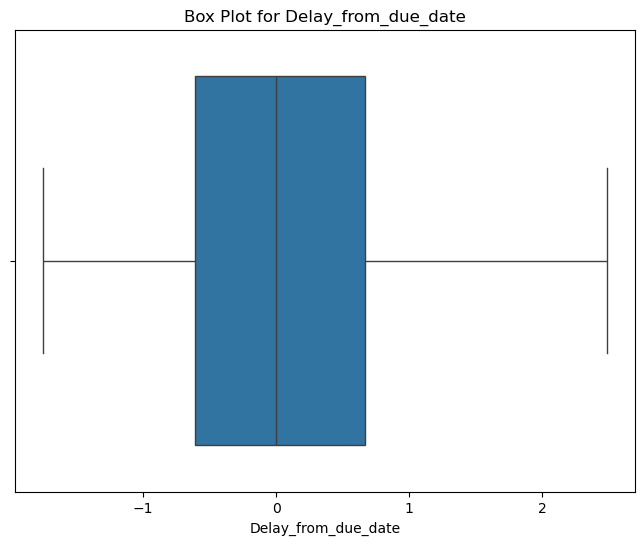

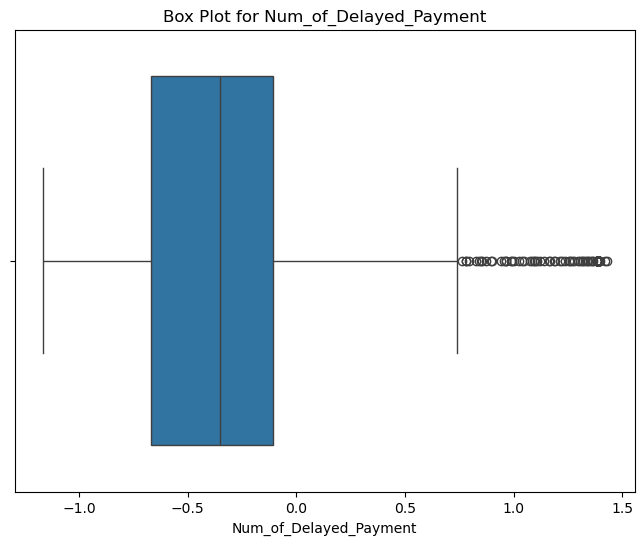

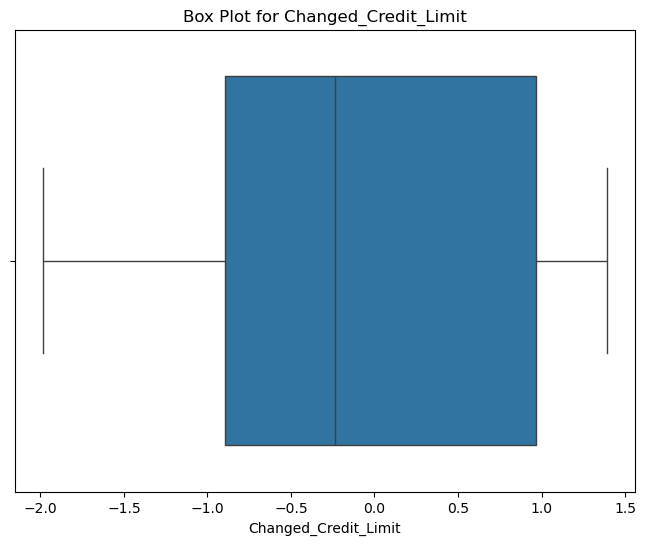

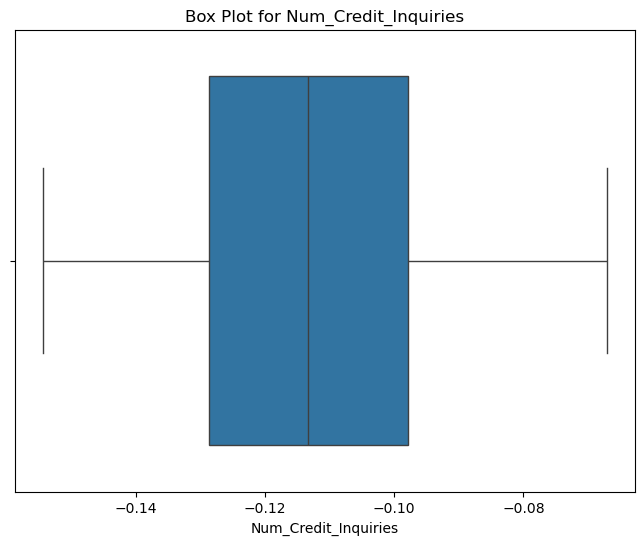

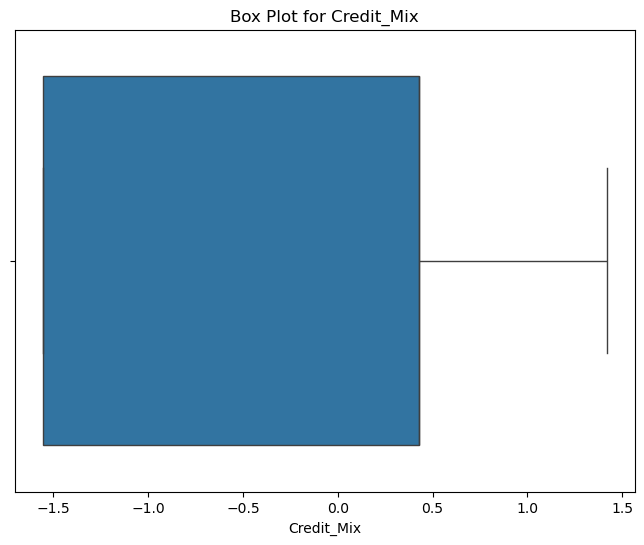

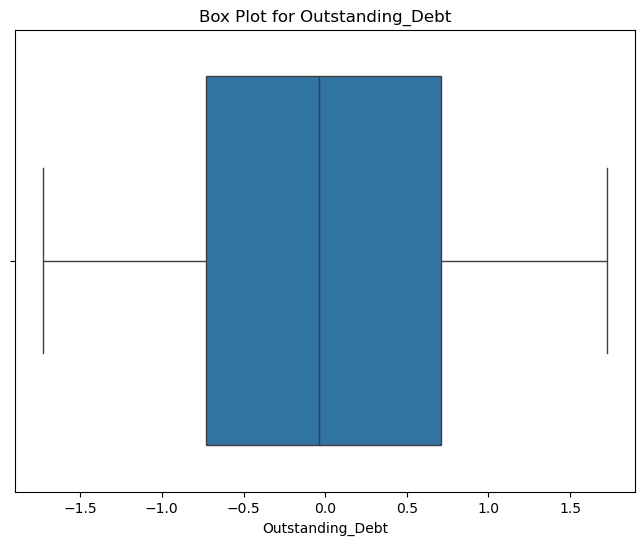

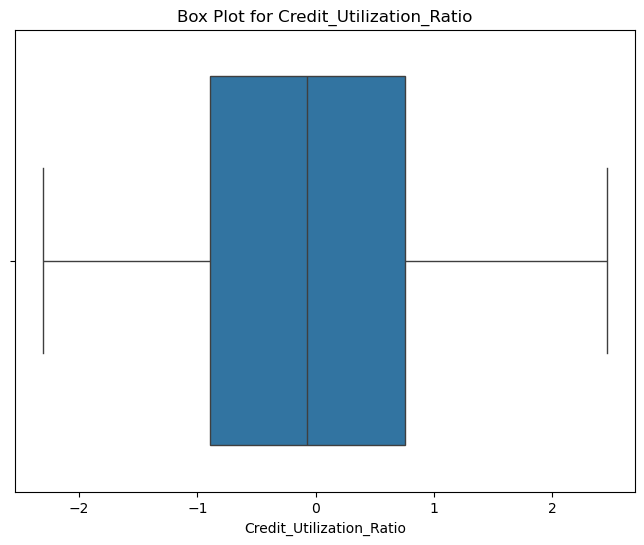

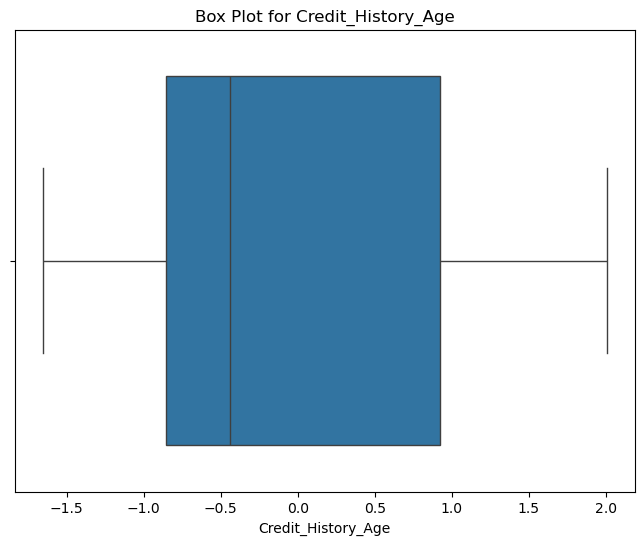

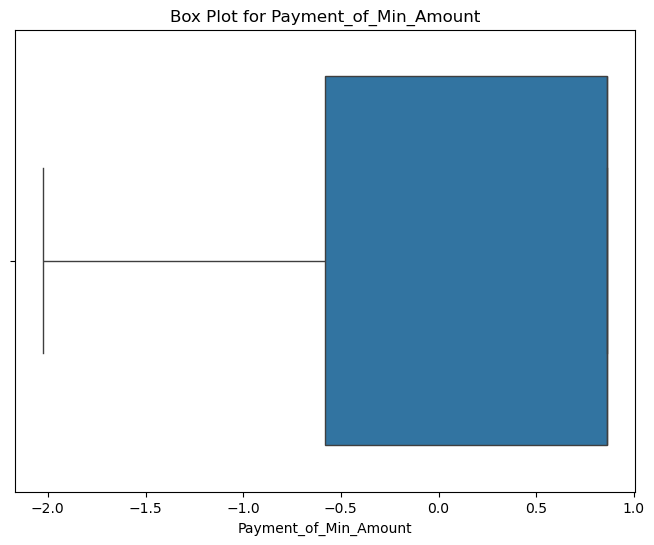

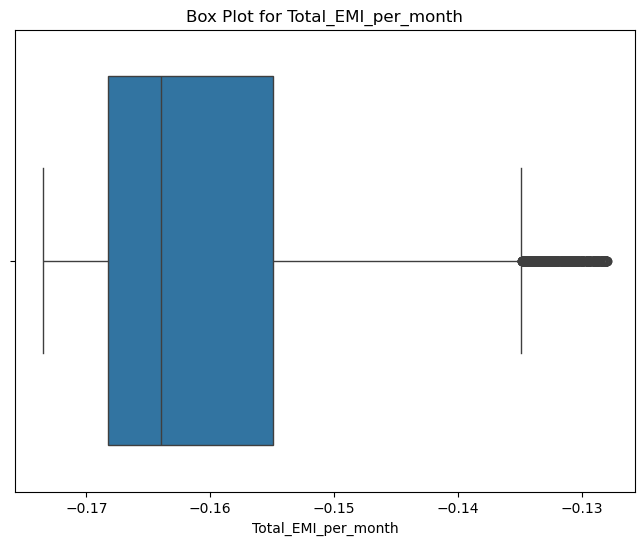

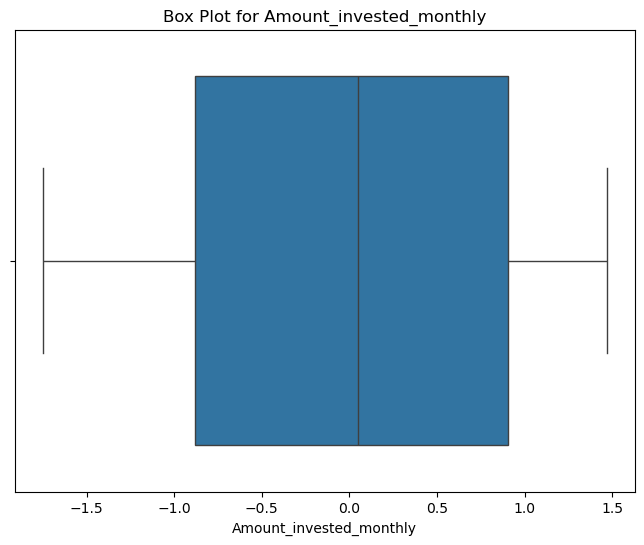

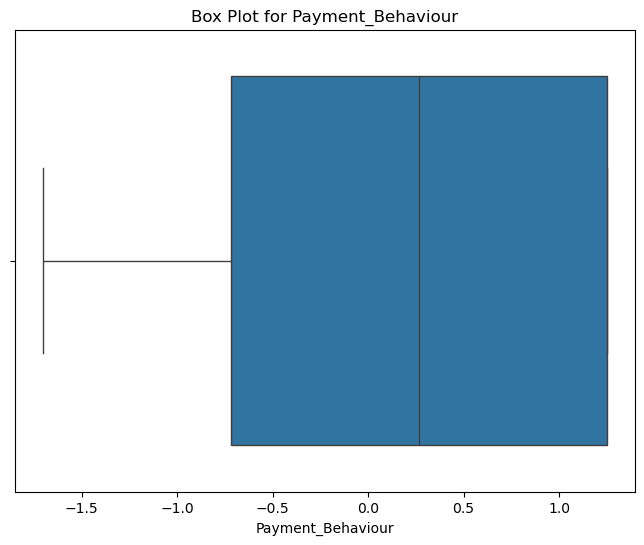

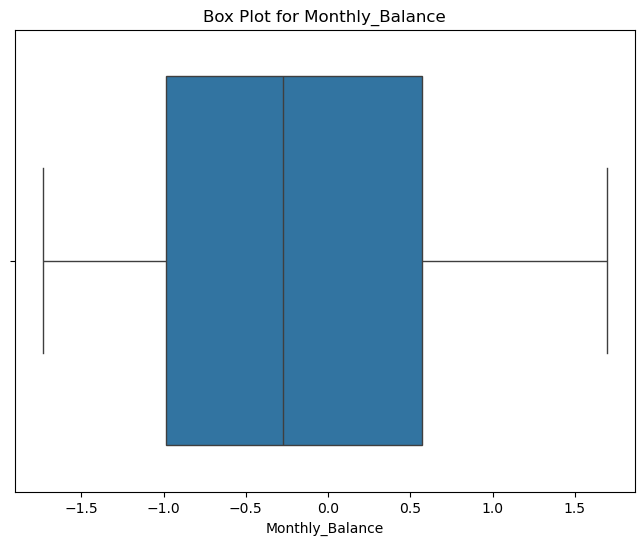

In [60]:
# Boxplot for numerical features
for col in numeric_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x=col)
    plt.title(f"Box Plot for {col}")
    plt.show()

## 3. Model Building
- Train multiple machine learning models using the preprocessed data.
- Evaluate the suitability of various models for the task.


In [61]:
# Define features (X) and target (y)
X = df.drop(columns=['Credit_Mix'])  
y = df['Credit_Mix']                 

In [62]:
# Encode target variable
le_target = LabelEncoder()
y = le_target.fit_transform(y)

In [63]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
# Initialize the models
model_lr = LogisticRegression()
model_rf = RandomForestClassifier()
model_svc = SVC(probability=True)

In [65]:
model_lr.fit(X_train, y_train)  # Train Logistic Regression

LogisticRegression()

In [66]:
model_rf.fit(X_train, y_train)  # Train Random Forest Classifier

RandomForestClassifier()

In [67]:
model_svc.fit(X_train, y_train)  # Train Support Vector Classifier

SVC(probability=True)

## 4. Model Evaluation
- Compute and plot evaluation metrics for all models, such as accuracy, precision, recall, F1-score, and AUC-ROC.
- Compare the performance of models across multiple metrics.


In [93]:
def evaluate_model_with_metrics(model, X_test, y_test):
    # Predict classes
    y_pred = model.predict(X_test)
    
    # Check if model supports predict_proba for AUC-ROC calculation
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)  # Probabilities for all classes
    else:
        y_prob = None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')  # Change average to 'macro' for multiclass
    recall = recall_score(y_test, y_pred, average='macro')  # Change average to 'macro'
    f1 = f1_score(y_test, y_pred, average='macro')  # Change average to 'macro'
    
    # Handle AUC-ROC for multiclass, only if model supports predict_proba
    if y_prob is not None:
        try:
            auc_roc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='macro')
        except ValueError:  # In case of any issues (e.g., if classes are imbalanced)
            auc_roc = None
    else:
        auc_roc = None

    # Return as dictionary
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "auc_roc": auc_roc}

# Dictionary to hold results
results = {
    "Logistic Regression": evaluate_model_with_metrics(model_lr, X_test, y_test),
    "Random Forest": evaluate_model_with_metrics(model_rf, X_test, y_test),
    "SVC": evaluate_model_with_metrics(model_svc, X_test, y_test)
}

# Print the results
print("Model Evaluation Metrics:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name.capitalize()}: {metric_value:.4f}")


Model Evaluation Metrics:

Logistic Regression:
Accuracy: 0.6702
Precision: 0.5466
Recall: 0.6009
F1: 0.5527
Auc_roc: 0.8015

Random Forest:
Accuracy: 0.7599
Precision: 0.6236
Recall: 0.7094
F1: 0.6497
Auc_roc: 0.8375

SVC:
Accuracy: 0.6829
Precision: 0.5021
Recall: 0.6353
F1: 0.5603
Auc_roc: 0.8143


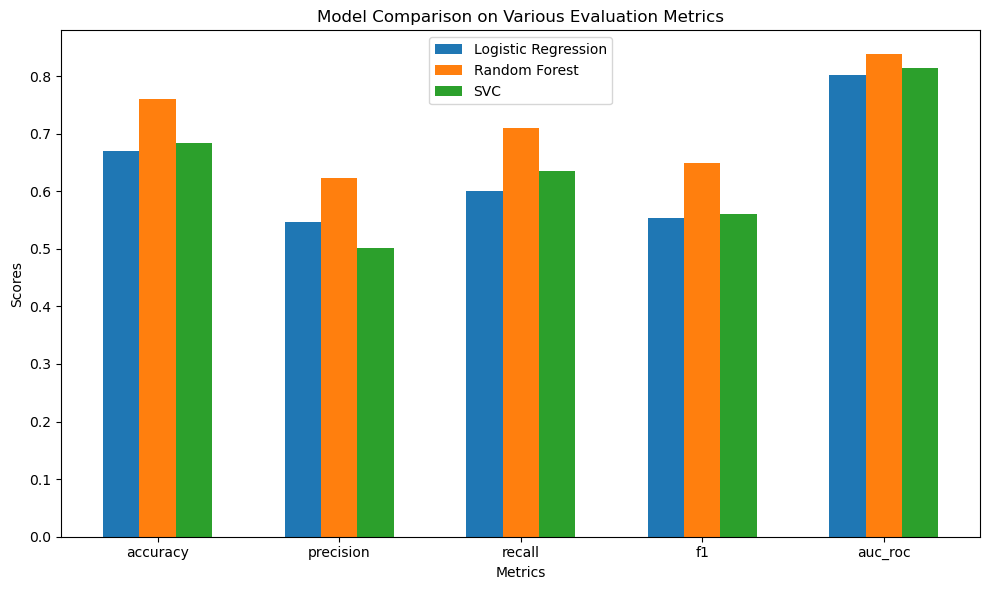

In [94]:
# Plotting
metrics_names = ["accuracy", "precision", "recall", "f1", "auc_roc"]
model_names = list(results.keys())
metric_values = np.array([[results[model_name][metric] for metric in metrics_names] for model_name in model_names])

# Create the bar plot
x = np.arange(len(metrics_names))  # The label locations
width = 0.2  # The width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for each model
for i, model_name in enumerate(model_names):
    ax.bar(x + i * width, metric_values[i], width, label=model_name)

# Add some text for labels, title and custom x-axis tick labels
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Comparison on Various Evaluation Metrics')
ax.set_xticks(x + width)
ax.set_xticklabels(metrics_names)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

## 5. Hyperparameter Tuning
- Optimize hyperparameters for each model using systematic search methods.
- Identify the best configuration for improved performance.


In [95]:
from sklearn.model_selection import GridSearchCV

In [96]:
# Define the parameter grids for each model
param_grids = {
    "Logistic Regression": {"C": [0.1, 1, 10], "solver": ["liblinear", "saga"], "max_iter": [100, 200, 300]},
    "Random Forest": {"n_estimators": [50, 100, 200], "max_depth": [10, 20, None], "min_samples_split": [2, 10, 20]},
    "SVC": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"], "gamma": ["scale", "auto"]}
}

In [97]:
# Dictionary to store the best models
best_models = {}


In [98]:
# Perform GridSearchCV for each model
for name, model in zip(["Logistic Regression", "Random Forest", "SVC"], [model_lr, model_rf, model_svc]):
    print(f"Performing GridSearchCV for {name}...")
    grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

Performing GridSearchCV for Logistic Regression...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters for Logistic Regression: {'C': 10, 'max_iter': 300, 'solver': 'saga'}
Performing GridSearchCV for Random Forest...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}
Performing GridSearchCV for SVC...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for SVC: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


## 6. Retrain Models
- Retrain all models using the optimal hyperparameters on the training data.
- Validate the models on unseen data to ensure robustness.

In [99]:
# Retrain models 
for name, model in best_models.items():
    model.fit(X_train, y_train)

## 7. Final Performance and Cross-Validation
- Evaluate the final performance of each model using cross-validation scores.
- Compare results to select the best-performing model.


In [100]:
from sklearn.model_selection import cross_val_score

for name, model in best_models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    print(f"\n{name} Cross-Validation Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f})")


Logistic Regression Cross-Validation Accuracy: 0.69 (+/- 0.00)

Random Forest Cross-Validation Accuracy: 0.73 (+/- 0.03)

SVC Cross-Validation Accuracy: 0.71 (+/- 0.00)


## 8. Suggestions
- Provide recommendations based on the model insights and analysis.
- Suggest actionable steps to improve outcomes or address any gaps identified during the project.
